In [1]:
import math 
import pandas_datareader as web
import numpy as np
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [2]:
df = web.DataReader('TSLA', data_source='yahoo', start='2012-01-01', end='2019-01-01')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,5.900000,5.530000,5.788000,5.616000,4640500,5.616000
2012-01-04,5.734000,5.500000,5.642000,5.542000,3150500,5.542000
2012-01-05,5.586000,5.370000,5.552000,5.424000,5027500,5.424000
2012-01-06,5.558000,5.282000,5.440000,5.382000,4931500,5.382000
2012-01-09,5.498000,5.224000,5.400000,5.450000,4485000,5.450000
...,...,...,...,...,...,...
2018-12-24,62.900002,59.040001,62.700001,59.077999,27799500,59.077999
2018-12-26,65.393997,58.818001,60.000000,65.218002,40815500,65.218002
2018-12-27,64.433998,60.299999,63.967999,63.226002,42875500,63.226002


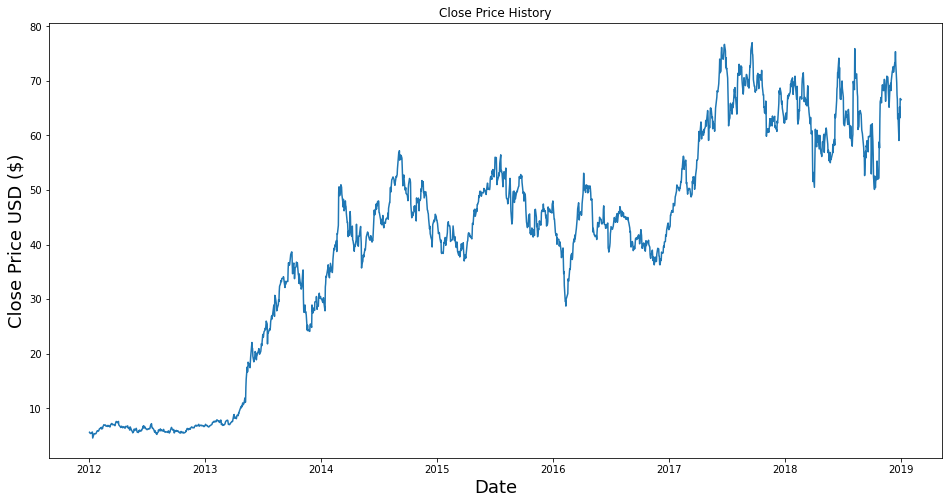

In [3]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [4]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8)

training_data_len

1408

In [5]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.01460479],
       [0.01358328],
       [0.01195439],
       ...,
       [0.80986171],
       [0.85883882],
       [0.85588467]])

In [6]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []


for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])


In [7]:
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1348, 60, 1)

In [8]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [9]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=32, epochs=20, verbose=2)

Epoch 1/20
43/43 - 4s - loss: 0.0180 - 4s/epoch - 91ms/step
Epoch 2/20
43/43 - 0s - loss: 0.0013 - 398ms/epoch - 9ms/step
Epoch 3/20
43/43 - 0s - loss: 0.0014 - 394ms/epoch - 9ms/step
Epoch 4/20
43/43 - 0s - loss: 0.0012 - 398ms/epoch - 9ms/step
Epoch 5/20
43/43 - 0s - loss: 0.0011 - 391ms/epoch - 9ms/step
Epoch 6/20
43/43 - 0s - loss: 0.0011 - 392ms/epoch - 9ms/step
Epoch 7/20
43/43 - 0s - loss: 0.0010 - 383ms/epoch - 9ms/step
Epoch 8/20
43/43 - 0s - loss: 0.0012 - 382ms/epoch - 9ms/step
Epoch 9/20
43/43 - 0s - loss: 9.3063e-04 - 378ms/epoch - 9ms/step
Epoch 10/20
43/43 - 0s - loss: 0.0011 - 384ms/epoch - 9ms/step
Epoch 11/20
43/43 - 0s - loss: 8.7684e-04 - 383ms/epoch - 9ms/step
Epoch 12/20
43/43 - 0s - loss: 8.0774e-04 - 393ms/epoch - 9ms/step
Epoch 13/20
43/43 - 0s - loss: 8.9091e-04 - 408ms/epoch - 9ms/step
Epoch 14/20
43/43 - 0s - loss: 8.2478e-04 - 378ms/epoch - 9ms/step
Epoch 15/20
43/43 - 0s - loss: 7.4159e-04 - 382ms/epoch - 9ms/step
Epoch 16/20
43/43 - 0s - loss: 6.8813e-04 

In [10]:
test_data = scaled_data[training_data_len - 60:, :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range (60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [11]:
x_test = np.array(x_test)

In [12]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [13]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [14]:
RMSE = np.sqrt(np.mean(predictions - y_test)**2)
RMSE

0.7344670620831576

<ipython-input-15-26b30eb7840b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


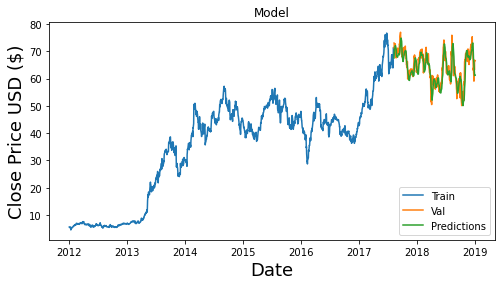

In [15]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize=(8,4))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [16]:
valid

,Close,Predictions
Date,,
2017-08-08,73.043999,67.564140
2017-08-09,72.706001,68.867035
2017-08-10,71.080002,70.075493
2017-08-11,71.573997,70.799797
2017-08-14,72.760002,71.266098
...,...,...
2018-12-24,59.077999,65.579147
2018-12-26,65.218002,63.183075
2018-12-27,63.226002,61.974850


In [20]:
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-11-01', end='2019-11-01')
new_df = apple_quote.filter(['Close'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test = []
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)
predicted_price


array([[61.667538]], dtype=float32)

In [22]:
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2019-11-01', end='2019-11-01')
print(apple_quote2['Close'])	


Date
2019-11-01    63.955002
Name: Close, dtype: float64
